# **Sección 1: Modelo Pro, XGBoost**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
import seaborn as sns
import shap

c:\Users\56940\Code\XAI\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **1.1 Cargar Data**

In [2]:
ar_path = './Caracterizacion.xlsx'
ar_df = pd.read_excel(ar_path)

---

## **1.2 Train-Test Split**

In [3]:
scaler = StandardScaler()
X = ar_df.drop(columns=['clase', 'fecha_inicio','fecha_fin'])
y = ar_df['clase']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

---

## **1.3 Modelo Simple y Directo**

In [ ]:
model = XGBClassifier(eval_metric='logloss')
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.44      0.40      0.42        10
           1       0.78      0.81      0.79        26

    accuracy                           0.69        36
   macro avg       0.61      0.60      0.61        36
weighted avg       0.69      0.69      0.69        36

              precision    recall  f1-score   support

           0       0.44      0.40      0.42        10
           1       0.78      0.81      0.79        26

    accuracy                           0.69        36
   macro avg       0.61      0.60      0.61        36
weighted avg       0.69      0.69      0.69        36



## **1.4 Búsqueda en Grilla de Párametros**

In [ ]:
# Definir el espacio de búsqueda de parámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 10, 100]
}

# Configurar la búsqueda en grilla
grid_search = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=3,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 6561 candidates, totalling 32805 fits

Mejores parámetros encontrados:
colsample_bytree: 0.8
gamma: 0.1
learning_rate: 0.2
max_depth: 3
n_estimators: 200
reg_alpha: 0.1
reg_lambda: 100
subsample: 0.9

Evaluación del mejor modelo:
              precision    recall  f1-score   support

           0       0.62      0.50      0.56        10
           1       0.82      0.88      0.85        26

    accuracy                           0.78        36
   macro avg       0.72      0.69      0.70        36
weighted avg       0.77      0.78      0.77        36

Matriz de confusión:
[[ 5  5]
 [ 3 23]]


In [10]:
print("\nMejores parámetros encontrados:")
print("================================")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")


Mejores parámetros encontrados:
colsample_bytree: 0.8
gamma: 0.1
learning_rate: 0.2
max_depth: 3
n_estimators: 200
reg_alpha: 0.1
reg_lambda: 100
subsample: 0.9


---

# **Sección 2: Evaluación del Modelo**

## **2.1 Classification Report**

In [ ]:
y_pred = best_model.predict(X_test_scaled)
print("\nEvaluación del mejor modelo:")
print("=============================")
print(classification_report(y_test, y_pred))



Evaluación del mejor modelo:
              precision    recall  f1-score   support

           0       0.62      0.50      0.56        10
           1       0.82      0.88      0.85        26

    accuracy                           0.78        36
   macro avg       0.72      0.69      0.70        36
weighted avg       0.77      0.78      0.77        36

Matriz de confusión:
[[ 5  5]
 [ 3 23]]


---

## **2.2 Confusion Matrix**

Text(70.72222222222221, 0.5, 'True')

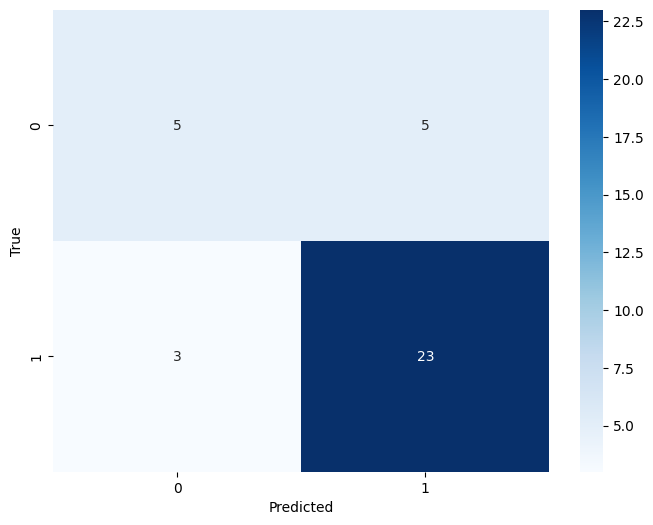

In [9]:

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

---

# **Sección 3: Explicabilidad con Shap**

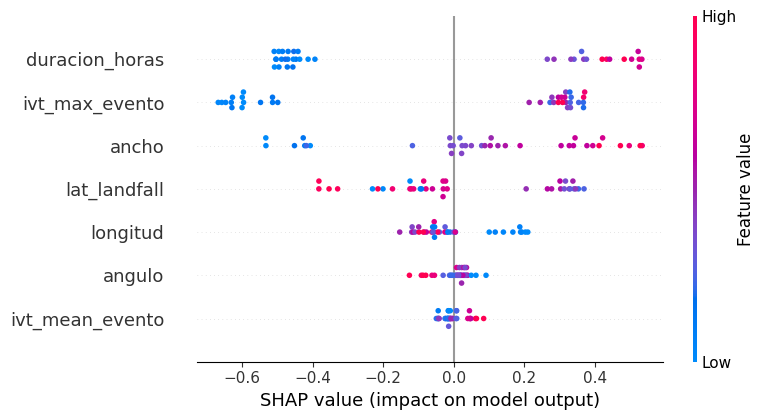

In [11]:
explainer = shap.Explainer(best_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

# Summary Plot
shap.summary_plot(shap_values, features=X_test_scaled, feature_names=X.columns)

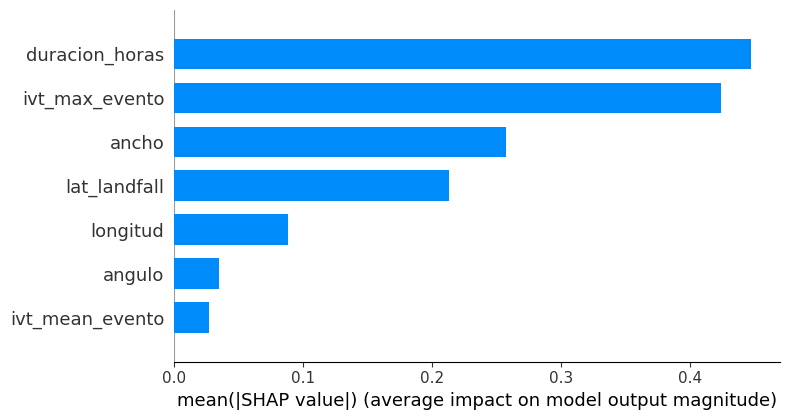

In [12]:
shap.summary_plot(shap_values, features=X_test_scaled, feature_names=X.columns, plot_type="bar")

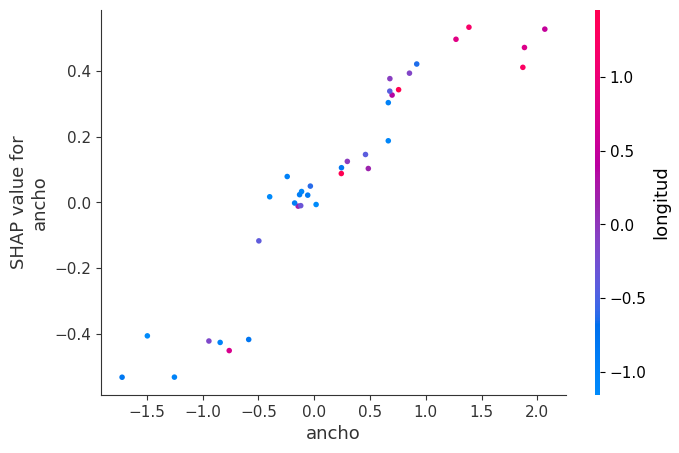

In [13]:
shap.dependence_plot("ancho", shap_values.values, features=X_test_scaled, feature_names=X.columns)

In [14]:
# Optional: Force Plot for the first prediction
shap.initjs()
shap.plots.force(shap_values[0])